In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


2024-10-22 18:23:11.212897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install statsmodels --user





In [3]:
df=pd.read_csv('/Users/irenexu/Desktop/irenexu/BTC-USD_historical_data.csv')

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-01,10795.254883,10933.624023,10472.356445,10619.452148,10619.452148,40023134100
1,2020-10-02,10619.821289,10657.837891,10416.689453,10575.974609,10575.974609,48661453918
2,2020-10-03,10575.100586,10598.940430,10511.129883,10549.329102,10549.329102,44660271563
3,2020-10-04,10550.440430,10686.000000,10534.391602,10669.583008,10669.583008,71251776995
4,2020-10-05,10676.529297,10793.507812,10634.600586,10793.339844,10793.339844,47537578009
...,...,...,...,...,...,...,...
1456,2024-09-26,63138.546875,65790.796875,62669.269531,65181.019531,65181.019531,36873129847
1457,2024-09-27,65180.664062,66480.695312,64852.992188,65790.664062,65790.664062,32058813449
1458,2024-09-28,65792.179688,66255.531250,65458.035156,65887.648438,65887.648438,15243637984
1459,2024-09-29,65888.898438,66069.343750,65450.015625,65635.304688,65635.304688,14788214575


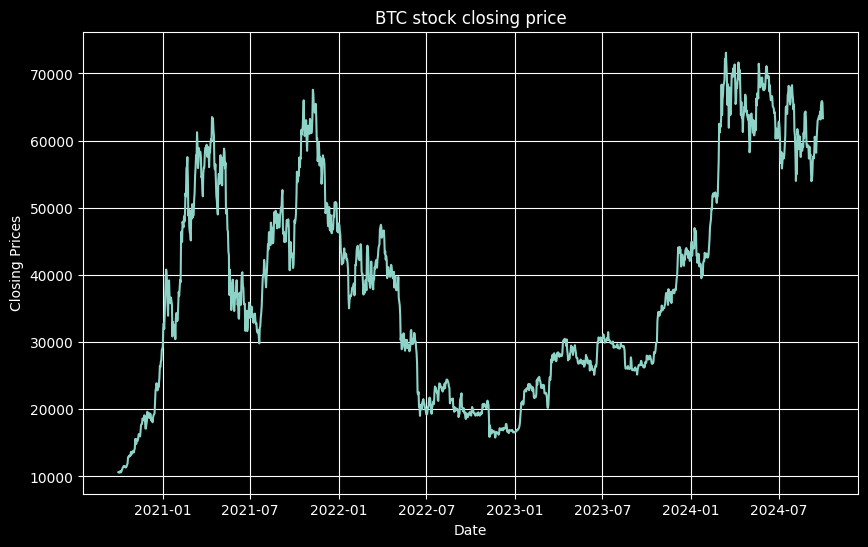

In [5]:
# Ensure that the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Plotting the data again
df_close = df['Close']
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('BTC stock closing price')  # Updated title for consistency
plt.show()


In [6]:
#test for stationarity 

def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''

    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

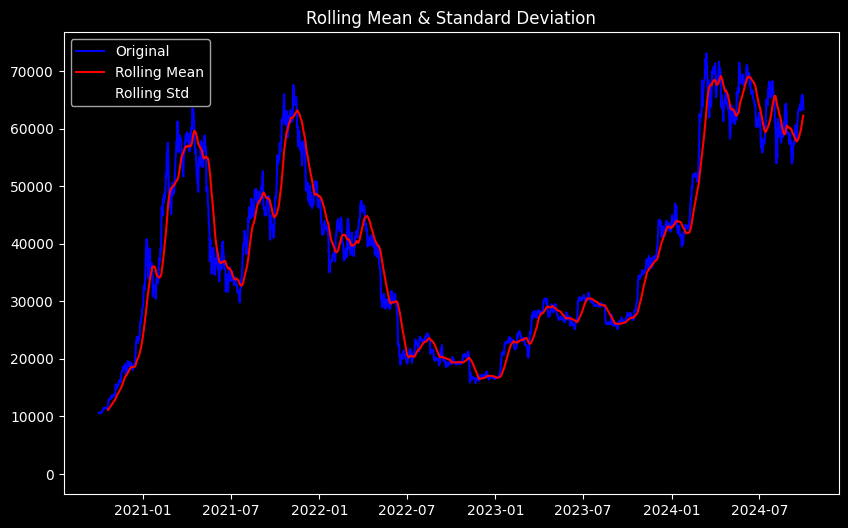

Results of Dickey-Fuller Test:
Test Statistic                   -1.625709
p-value                           0.469738
#Lags Used                        1.000000
Number of Observations Used    1459.000000
Critical Value (1%)              -3.434840
Critical Value (5%)              -2.863523
Critical Value (10%)             -2.567826
dtype: float64


In [7]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

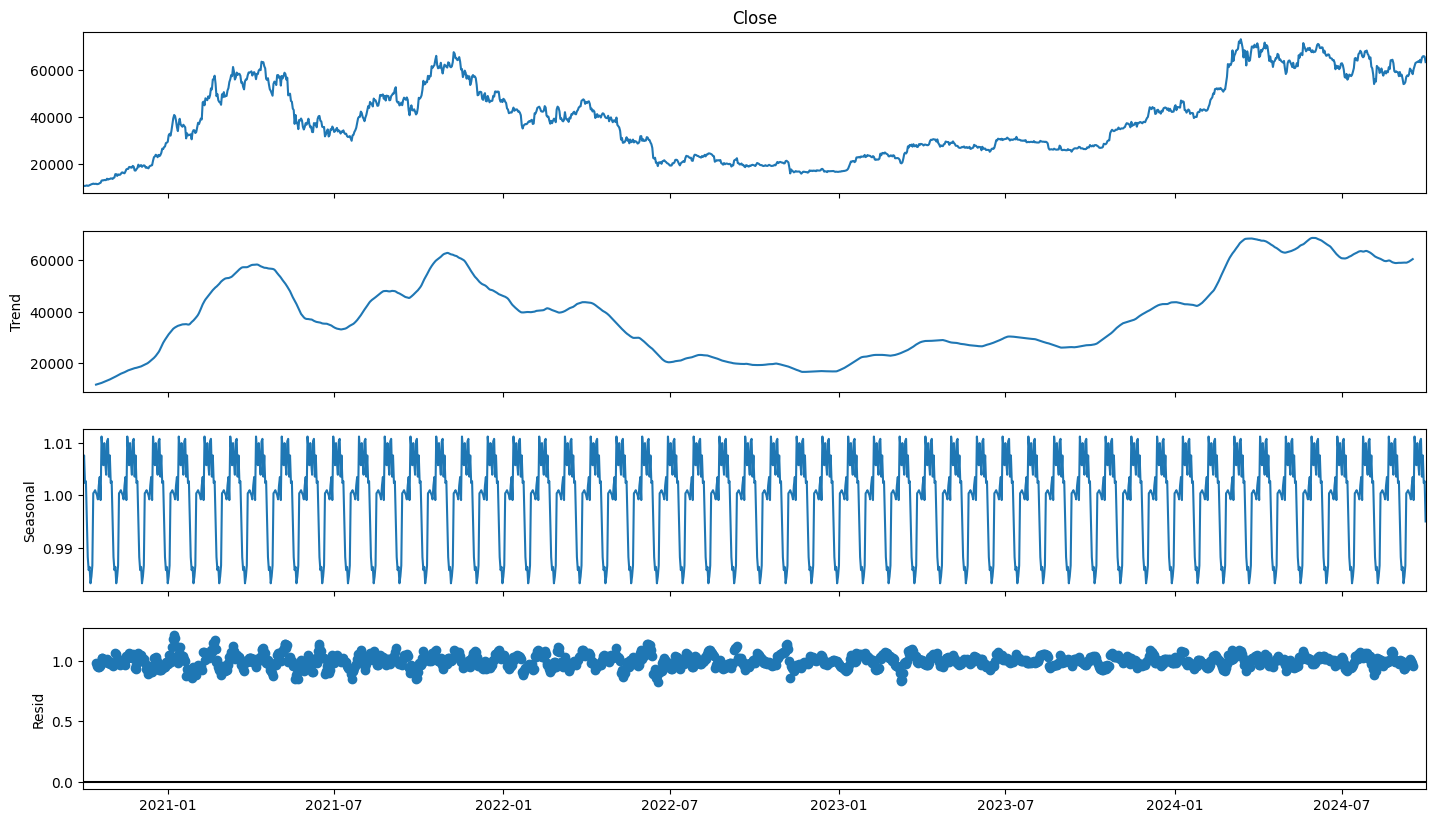

In [8]:
plt.style.use('default')
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

Text(0.5, 1.0, 'Transformed data')

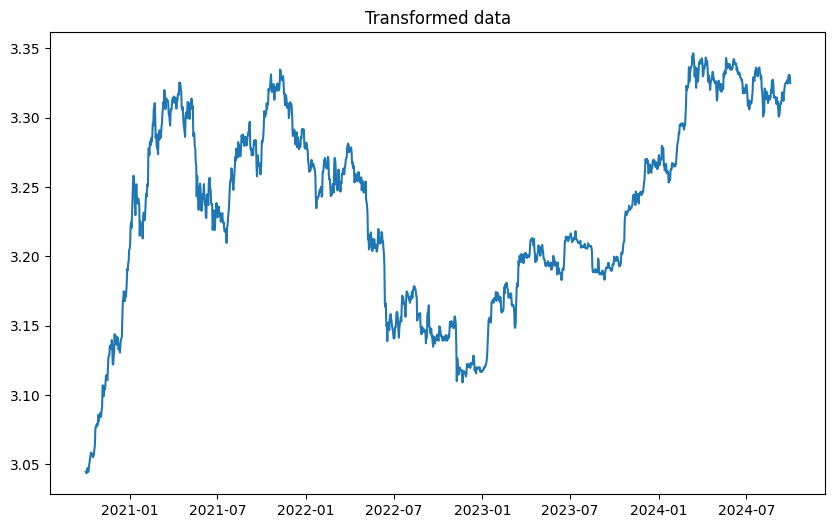

In [9]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)
plt.style.use('default')
plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

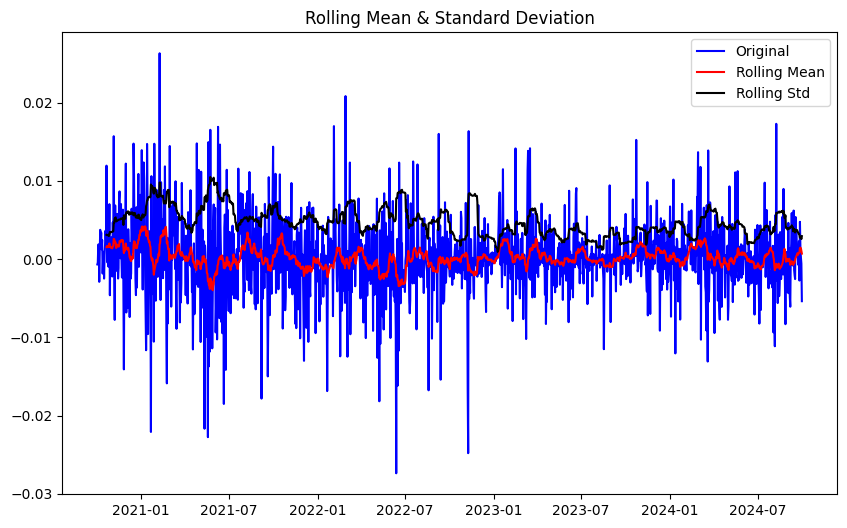

Results of Dickey-Fuller Test:
Test Statistic                  -39.115877
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1459.000000
Critical Value (1%)              -3.434840
Critical Value (5%)              -2.863523
Critical Value (10%)             -2.567826
dtype: float64


In [10]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [11]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix >= len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [12]:
#select prediction timeframe 
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

In [13]:
#seperate into training and testing set 
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

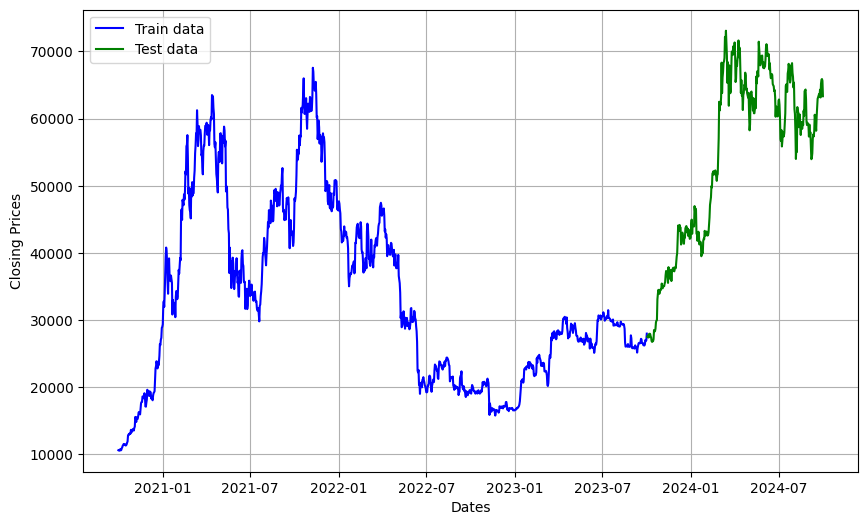

In [14]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [15]:
#define LSTM model for multistep forecasting

def vanilla_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

In [16]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/Users/irenexu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 4.1764e-05 - mean_absolute_error: 0.0050
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.7716e-05 - mean_absolute_error: 0.0037
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.9241e-05 - mean_absolute_error: 0.0038
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.0130e-05 - mean_absolute_error: 0.0040
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.0515e-05 - mean_absolute_error: 0.0039
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.9646e-05 - mean_absolute_error: 0.0038
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.1549e-05 - mean_absolute_error: 0.0039
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.9175e-05 - mean_absolute_error: 0.0038
Epoch 9/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.7730e-05 - mean_absolute_error: 0.0037
Epoch 10/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3.1440e-05 - mean_absolute_error: 0.0039

In [18]:
#evaluating model using test data 
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7815e-05 - mean_absolute_error: 0.0030
Test MSE: 1.8443422959535383e-05
Test MAE: 0.00312883616425097


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


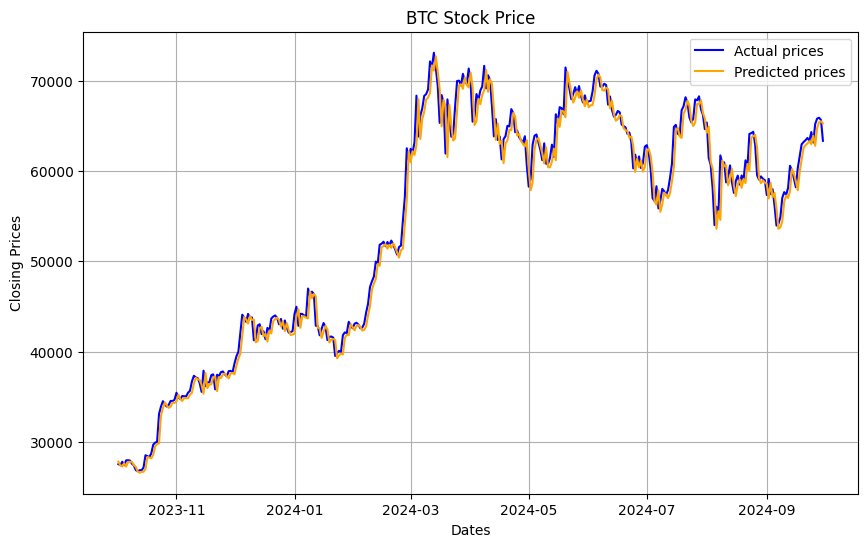

In [19]:
#prediciton analysis 
y_pred = model.predict(X_test)

pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:]

pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title('BTC' + ' Stock Price')

plt.legend()

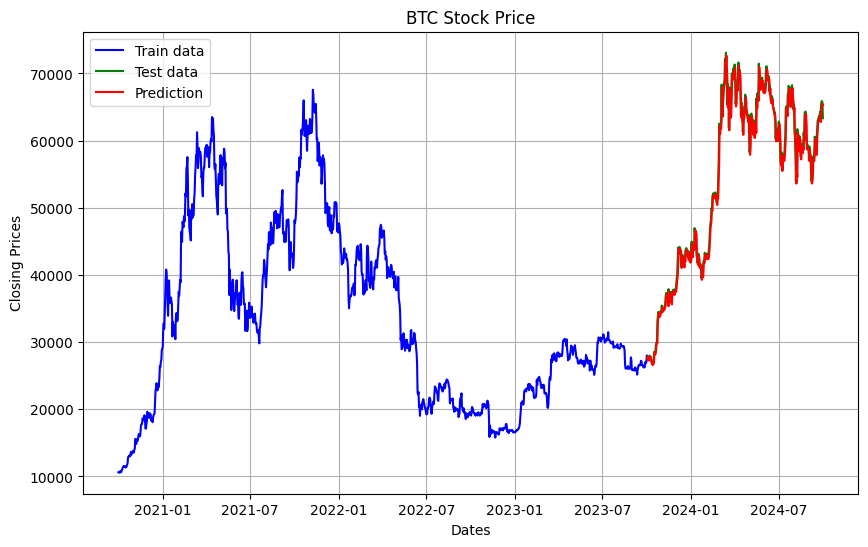

In [20]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'red', label='Prediction')
plt.title('BTC' + ' Stock Price')
plt.legend()

In [21]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))

    return X, y

In [22]:
#time horizon for future prediction compared to historical basis 
n_steps_out = 30

nb_days = 60

n_features = 1

X, y = preprocess_multistep_lstm(df_close_shift.to_numpy(), nb_days, n_steps_out, n_features)

In [23]:
#split dataset 
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]


In [24]:
def vanilla_multistep_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(n_steps_out))
    return model

In [25]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/Users/irenexu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,930 (46.60 KB)

 Trainable params: 11,930 (46.60 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0718e-05 - mean_absolute_error: 0.0039
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.0372e-05 - mean_absolute_error: 0.0038
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.8860e-05 - mean_absolute_error: 0.0037
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.9159e-05 - mean_absolute_error: 0.0038
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.9959e-05 - mean_absolute_error: 0.0038
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.9890e-05 - mean_absolute_error: 0.0038
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.9164e-05 - mean_absolute_error: 0.0038
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.8708e-05 - mean_absolute_error: 0.0037
Epoch 9/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.0104e-05 - mean_absolute_error: 0.0038
Epoch 10/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 3.0392e-05 - mean_absolute_error: 0.0039

In [27]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.5185e-05 - mean_absolute_error: 0.0027
Test MSE: 1.7330850823782384e-05
Test MAE: 0.003014014568179846


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

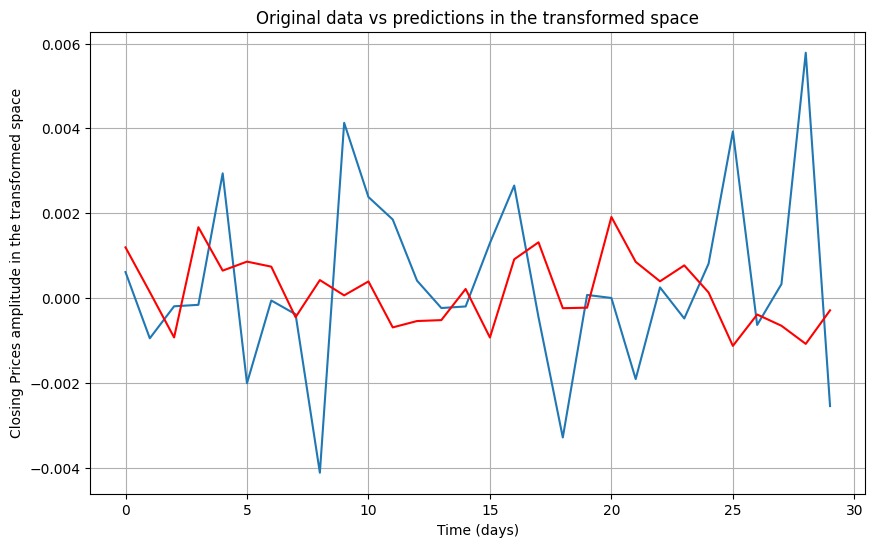

In [28]:
y_pred = model.predict(X_test)

the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Closing Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [29]:
pred_diff_cumsum = y_pred_days.cumsum()

base_number = df_close_tf.values[-test_days+the_day+nb_days-1]
idx = test_original.iloc[the_day:the_day+n_steps_out].index

pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum,fill_value=0)

print(pred_tf)

Date
2023-10-02    3.247382
2023-10-03    3.247521
2023-10-04    3.246589
2023-10-05    3.248257
2023-10-06    3.248901
2023-10-07    3.249757
2023-10-08    3.250495
2023-10-09    3.250040
2023-10-10    3.250461
2023-10-11    3.250521
2023-10-12    3.250910
2023-10-13    3.250215
2023-10-14    3.249670
2023-10-15    3.249147
2023-10-16    3.249358
2023-10-17    3.248424
2023-10-18    3.249335
2023-10-19    3.250647
2023-10-20    3.250405
2023-10-21    3.250175
2023-10-22    3.252084
2023-10-23    3.252935
2023-10-24    3.253327
2023-10-25    3.254094
2023-10-26    3.254223
2023-10-27    3.253092
2023-10-28    3.252701
2023-10-29    3.252044
2023-10-30    3.250960
2023-10-31    3.250668
dtype: float64


In [30]:
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

Date
2023-10-02    38005.738431
2023-10-03    38040.040711
2023-10-04    37810.492883
2023-10-05    38222.174720
2023-10-06    38382.505472
2023-10-07    38596.665912
2023-10-08    38782.189292
2023-10-09    38667.767000
2023-10-10    38773.688946
2023-10-11    38788.864531
2023-10-12    38887.017507
2023-10-13    38711.731277
2023-10-14    38574.815902
2023-10-15    38443.907348
2023-10-16    38496.601794
2023-10-17    38263.872690
2023-10-18    38491.036096
2023-10-19    38820.608802
2023-10-20    38759.564054
2023-10-21    38701.635576
2023-10-22    39185.139282
2023-10-23    39402.607243
2023-10-24    39503.202716
2023-10-25    39700.972550
2023-10-26    39734.134718
2023-10-27    39442.760383
2023-10-28    39342.496989
2023-10-29    39174.842461
2023-10-30    38899.768987
2023-10-31    38825.942613
dtype: float64


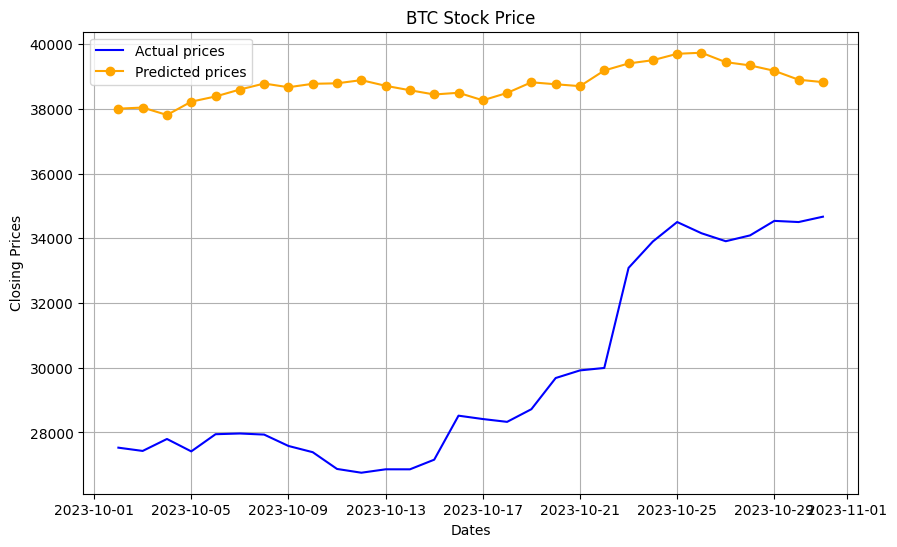

In [31]:
#plot actual price vs predicted price 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title('BTC' + ' Stock Price')

plt.legend()